# Task 1 : Set up colab gpu runtime environment

In [37]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /private/var/folders/8b/9szts30140zc5lt67txz1kwr0000gn/T/pip-req-build-4os13lnp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /private/var/folders/8b/9szts30140zc5lt67txz1kwr0000gn/T/pip-req-build-4os13lnp
  Resolved https://github.com/albumentations-team/albumentations to commit d13efeb7416e6697142f10ea312dd8a41b29e2da
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Libra

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [36]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


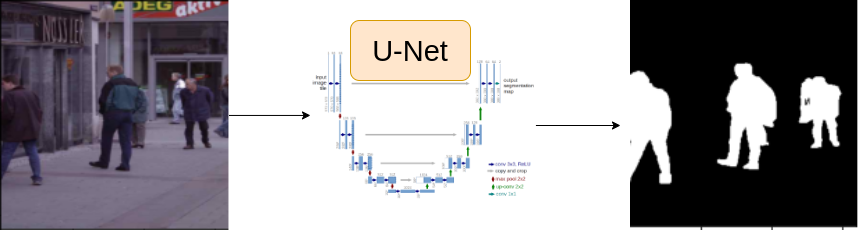

# Some Common Imports

In [3]:
import sys
sys.path.append('/Users/chakri/Research/MachineLearning/Computer_Vision/Image_segmentation/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [9]:
CSV_FILE='/Users/chakri/Research/MachineLearning/Computer_Vision/Image_segmentation/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/Users/chakri/Research/MachineLearning/Computer_Vision/Image_segmentation/Human-Segmentation-Dataset-master'

DEVICE='cuda'
EPOCHS = 25
LR = 0.003
WEIGHTS = 320
IMG_SIZE=320
BATCH_SIZE=16

ENCODER= 'timm-efficientnet-b0'
WEIGHTS='imagenet'

In [10]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [38]:
row= df.iloc[15]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

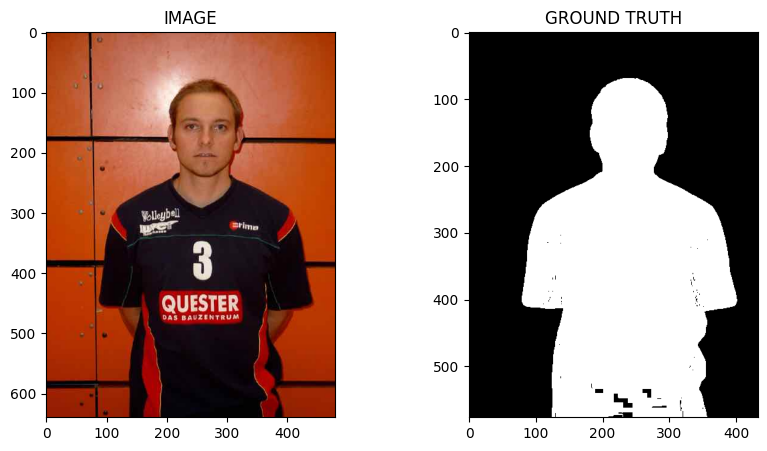

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [17]:
def get_train_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5)], is_check_shapes=False
  )
def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE)], is_check_shapes=False
)

# Task 4 : Create Custom Dataset

In [18]:
from torch.utils.data import Dataset

In [19]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row= self.df.iloc[idx]

    image_path=row.images
    mask_path= row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']

    #(h,w,c)->(c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask =np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [20]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


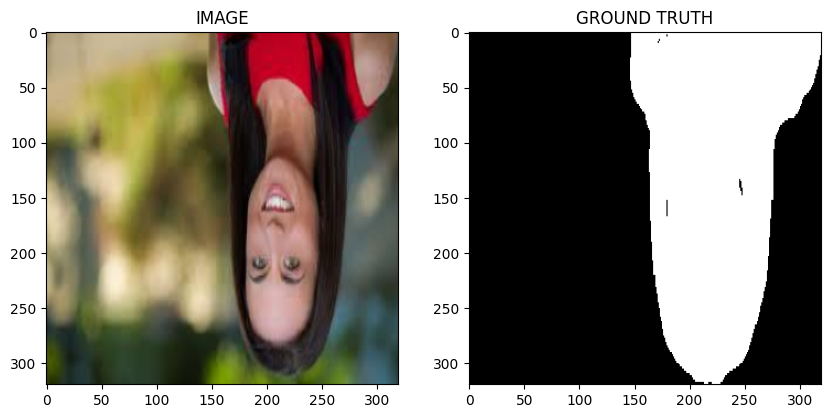

In [22]:
idx=22
image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [25]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in validloader: {len(validloader)}")

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [26]:
for image , mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch image shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch image shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [27]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [28]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc=smp.Unet(
      encoder_name=ENCODER,
      encoder_weights=WEIGHTS,
      in_channels=3,
      classes=1,
      activation=None
  )

  def forward(self, images, masks=None):
    logits=self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2

    return logits

In [29]:
model=SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /Users/chakri/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth


HTTPError: HTTP Error 502: Bad Gateway

# Task 7 : Create Train and Validation Function

In [30]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss=0.0

  for images, masks in data_loader:
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimize.zero_grad()
    logits,loss=model(images, masks)
    loss.background
    optimizer.step()
    total_loss+=loss.item()

  return total_loss/len(data_loader)

In [31]:
def eval_fn(data_loader, model, optimizer):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images, masks in data_loader:
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)
      logits,loss=model(images, masks)

      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [32]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

NameError: name 'model' is not defined

In [33]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss= eval_fn(validloader,model)

if valid_loss < best_valid_loss:
  torch.save(model.state.dict(),'best_model.pt')
  print("SAVED MODEL")
  best_valid_loss=valid_loss

print(f"Epoch: {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")

NameError: name 'model' is not defined

# Task 9 : Inference

In [34]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)

pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > 0.5)*1.0


NameError: name 'model' is not defined

In [35]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze())

NameError: name 'pred_mask' is not defined